In [1]:
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from eworm.network.transform import abstract2detailed
from eworm.utils import func

--No graphics will be displayed.
/home/zhaomengdi/anaconda3/envs/eworm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Synapse and gap junction weight histogram

In [2]:
DATA_PATH = "/home/zhaomengdi/Project/model_meta_worm/eworm/model_figure/network_dynamic/trial10"
OUTPUT_PATH = "/home/zhaomengdi/Project/model_meta_worm/eworm/model_figure/network_dynamic/figure"
config_file = os.path.join(DATA_PATH, "000_circuit_search_config.json")
abs_circuit_file = os.path.join(DATA_PATH, "optimal_abs_circuit.pkl")

In [3]:
main_config = func.load_json(os.path.join(DATA_PATH, config_file))
abs_circuit = pickle.load(open(os.path.join(DATA_PATH, abs_circuit_file), "rb"))
circuit = abstract2detailed(abs_circuit, main_config["config"], load_hoc=True, rec_voltage=True, mode="active")

gj_weight = []
syn_weight = []
exc_syn_weight = []
inh_syn_weight = []
for conn in circuit.connections:
    if conn.category == 'gj':
        gj_weight.append(conn.weight * 1e4)
    elif conn.category == 'syn':
        if conn.weight > 0:
            syn_weight.append(conn.weight * 4.9)
            exc_syn_weight.append(conn.weight * 4.9)
        elif conn.weight < 0:
            syn_weight.append(conn.weight * 2)
            inh_syn_weight.append(conn.weight * 2)

gap junction: num=786, G_total=382.91
synapse: num=1115, E_num=352, I_num=763, GE_total=1221.51, GI_total=-720.00


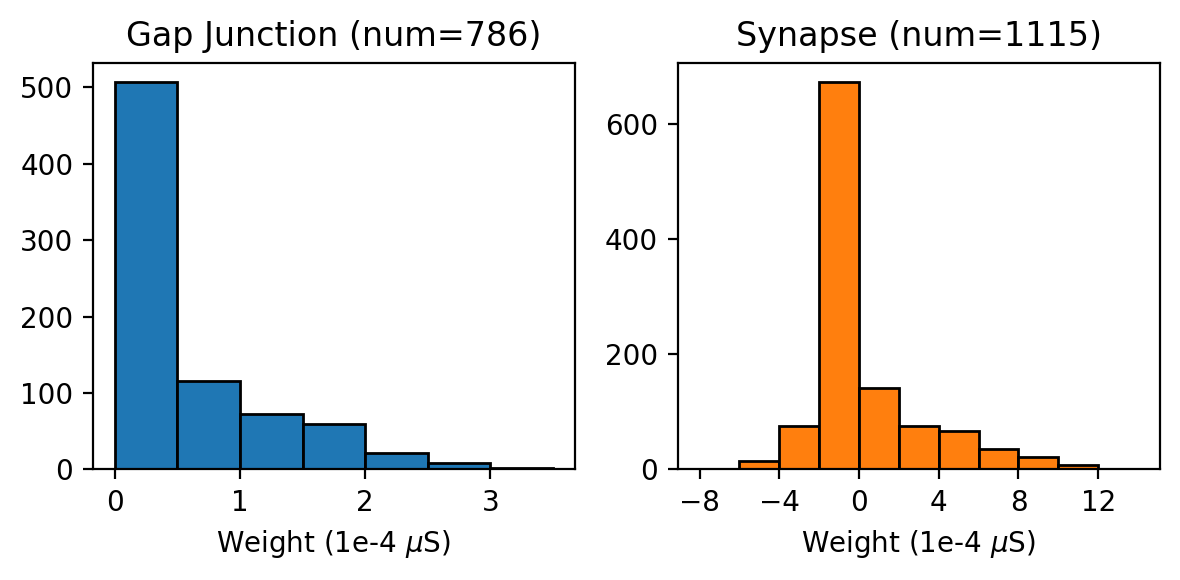

In [4]:
fig = plt.figure(figsize=(6,3), dpi=200)
ax = plt.subplot(1,2,1)
ax.hist(gj_weight, np.arange(0,4,0.5), edgecolor='k', color='C0')
plt.xlabel(r"Weight (1e-4 $\mu$S)")
plt.title(f"Gap Junction (num={len(gj_weight)})")
plt.tight_layout()
ax = fig.add_subplot(1,2,2)
ax.hist(syn_weight, np.arange(-8,16,2), edgecolor='k', color='C1')
plt.xticks(np.arange(-8,16,4))
plt.xlabel(r"Weight (1e-4 $\mu$S)")
plt.title(f"Synapse (num={len(syn_weight)})")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, "weight_histogram.png"))
# print conductance
print(f"gap junction: num={len(gj_weight)}, G_total={np.sum(np.array(gj_weight)):.2f}")
print(f"synapse: num={len(syn_weight)}, E_num={len(exc_syn_weight)}, I_num={len(inh_syn_weight)}, GE_total={np.sum(np.array(exc_syn_weight)):.2f}, GI_total={np.sum(np.array(inh_syn_weight)):.2f}")

Synapse and gap junction distribution in network

In [5]:
# weight distribution on cells (from high to low)
gj_weight.sort()
exc_syn_weight.sort()
inh_syn_weight.sort(reverse=True)
percentage_list = np.arange(0, 1, 0.02) # pruned percentage
cell_cnt_list = []
conn_cnt_list = []
for pc in percentage_list:
    gj_thresh = gj_weight[int(len(gj_weight)*pc)]
    exc_syn_thresh = exc_syn_weight[int(len(exc_syn_weight)*pc)]
    inh_syn_thresh = inh_syn_weight[int(len(inh_syn_weight)*pc)]
    high_weight_cell = {}   # cell_name(string): type: weights(list)
    tmp_cnt = 0
    tmp_trg = len(gj_weight) - int(len(gj_weight)*pc)
    for conn in circuit.connections:
        pre_name = conn.pre_cell.name
        post_name = conn.post_cell.name
        if conn.category == 'gj':
            if conn.weight > gj_thresh*1e-4:
                for name in [pre_name, post_name]:
                    if high_weight_cell.get(name, None):
                        high_weight_cell[name]['gj'].append(conn.weight)
                    else:
                        high_weight_cell[name] = {}
                        high_weight_cell[name]['gj'] = [conn.weight]
                        high_weight_cell[name]['syn'] = []
                tmp_cnt += 1
        if conn.category == 'syn':
            if conn.weight < 0 and abs(conn.weight*2e-4) > abs(inh_syn_thresh*1e-4):
                for name in [pre_name, post_name]:
                    if high_weight_cell.get(name, None):
                        high_weight_cell[name]['syn'].append(conn.weight*2e-4)
                    else:
                        high_weight_cell[name] = {}
                        high_weight_cell[name]['gj'] = []
                        high_weight_cell[name]['syn'] = [conn.weight*2e-4]
            if conn.weight > 0 and abs(conn.weight*4.9e-4) > abs(exc_syn_thresh*1e-4):
                for name in [pre_name, post_name]:
                    if high_weight_cell.get(name, None):
                        high_weight_cell[name]['syn'].append(conn.weight*4.9e-4)
                    else:
                        high_weight_cell[name] = {}
                        high_weight_cell[name]['gj'] = []
                        high_weight_cell[name]['syn'] = [conn.weight*4.9e-4]
    # a group of gap junctions have same weight
    for conn in circuit.connections:
        pre_name = conn.pre_cell.name
        post_name = conn.post_cell.name
        if conn.category == 'gj' and conn.weight == gj_thresh*1e-4 and tmp_cnt < tmp_trg:
            for name in [pre_name, post_name]:
                if high_weight_cell.get(name, None):
                    high_weight_cell[name]['gj'].append(conn.weight)
                else:
                    high_weight_cell[name] = {}
                    high_weight_cell[name]['gj'] = [conn.weight]
                    high_weight_cell[name]['syn'] = []
            tmp_cnt += 1
    cell_cnt = 0
    conn_cnt = 0
    for cell_name, item in high_weight_cell.items():
        cell_cnt += 1
        for ctype, weights in item.items():
            conn_cnt += len(weights)
    cell_cnt_list.append(int(cell_cnt))
    conn_cnt_list.append(int(conn_cnt/2))

percentage_list = np.insert(percentage_list, percentage_list.shape[0], 1)*100
cell_cnt_list.append(0)
conn_cnt_list.append(0)
print(percentage_list)
print(cell_cnt_list)
print(conn_cnt_list)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100.]
[136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 134, 133, 133, 132, 131, 129, 126, 123, 118, 106, 91, 81, 61, 35, 0]
[1899, 1862, 1824, 1786, 1748, 1710, 1672, 1634, 1596, 1558, 1520, 1483, 1444, 1406, 1368, 1331, 1292, 1254, 1217, 1179, 1140, 1102, 1065, 1027, 988, 949, 912, 873, 835, 798, 760, 721, 683, 646, 608, 569, 532, 494, 456, 417, 380, 342, 304, 266, 228, 190, 152, 114, 76, 38, 0]


In [9]:
# weight distribution on cells (from low to high)
gj_weight.sort(reverse=True)
exc_syn_weight.sort(reverse=True)
inh_syn_weight.sort()
percentage_list = np.arange(0, 1, 0.02) # pruned percentage
cell_cnt_list2 = []
conn_cnt_list2 = []
for pc in percentage_list:
    gj_thresh = gj_weight[int(len(gj_weight)*pc)]
    exc_syn_thresh = exc_syn_weight[int(len(exc_syn_weight)*pc)]
    inh_syn_thresh = inh_syn_weight[int(len(inh_syn_weight)*pc)]
    high_weight_cell = {}   # cell_name(string): type: weights(list)
    tmp_cnt = 0
    tmp_trg = len(gj_weight) - int(len(gj_weight)*pc)
    for conn in circuit.connections:
        pre_name = conn.pre_cell.name
        post_name = conn.post_cell.name
        if conn.category == 'gj':
            if conn.weight < gj_thresh*1e-4:
                for name in [pre_name, post_name]:
                    if high_weight_cell.get(name, None):
                        high_weight_cell[name]['gj'].append(conn.weight)
                    else:
                        high_weight_cell[name] = {}
                        high_weight_cell[name]['gj'] = [conn.weight]
                        high_weight_cell[name]['syn'] = []
                tmp_cnt += 1
        if conn.category == 'syn':
            if conn.weight < 0 and abs(conn.weight*2e-4) < abs(inh_syn_thresh*1e-4):
                for name in [pre_name, post_name]:
                    if high_weight_cell.get(name, None):
                        high_weight_cell[name]['syn'].append(conn.weight*2e-4)
                    else:
                        high_weight_cell[name] = {}
                        high_weight_cell[name]['gj'] = []
                        high_weight_cell[name]['syn'] = [conn.weight*2e-4]
            if conn.weight > 0 and abs(conn.weight*4.9e-4) < abs(exc_syn_thresh*1e-4):
                for name in [pre_name, post_name]:
                    if high_weight_cell.get(name, None):
                        high_weight_cell[name]['syn'].append(conn.weight*4.9e-4)
                    else:
                        high_weight_cell[name] = {}
                        high_weight_cell[name]['gj'] = []
                        high_weight_cell[name]['syn'] = [conn.weight*4.9e-4]
    # a group of gap junctions have same weight
    for conn in circuit.connections:
        pre_name = conn.pre_cell.name
        post_name = conn.post_cell.name
        if conn.category == 'gj' and conn.weight == gj_thresh*1e-4 and tmp_cnt < tmp_trg:
            for name in [pre_name, post_name]:
                if high_weight_cell.get(name, None):
                    high_weight_cell[name]['gj'].append(conn.weight)
                else:
                    high_weight_cell[name] = {}
                    high_weight_cell[name]['gj'] = [conn.weight]
                    high_weight_cell[name]['syn'] = []
            tmp_cnt += 1
    cell_cnt = 0
    conn_cnt = 0
    for cell_name, item in high_weight_cell.items():
        cell_cnt += 1
        for ctype, weights in item.items():
            conn_cnt += len(weights)
    cell_cnt_list2.append(int(cell_cnt))
    conn_cnt_list2.append(int(conn_cnt/2))

percentage_list = np.insert(percentage_list, percentage_list.shape[0], 1)*100
cell_cnt_list2.append(0)
conn_cnt_list2.append(0)
print(percentage_list)
print(cell_cnt_list2)
print(conn_cnt_list2)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100.]
[136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 134, 134, 134, 134, 134, 134, 134, 134, 133, 133, 131, 131, 130, 128, 125, 122, 116, 115, 110, 103, 99, 81, 70, 56, 0]
[1900, 1863, 1825, 1786, 1748, 1711, 1673, 1635, 1597, 1559, 1520, 1483, 1444, 1406, 1369, 1331, 1293, 1254, 1217, 1179, 1141, 1103, 1066, 1028, 989, 950, 913, 873, 835, 798, 761, 722, 684, 647, 608, 570, 532, 495, 457, 418, 381, 342, 305, 266, 228, 191, 153, 115, 77, 39, 0]


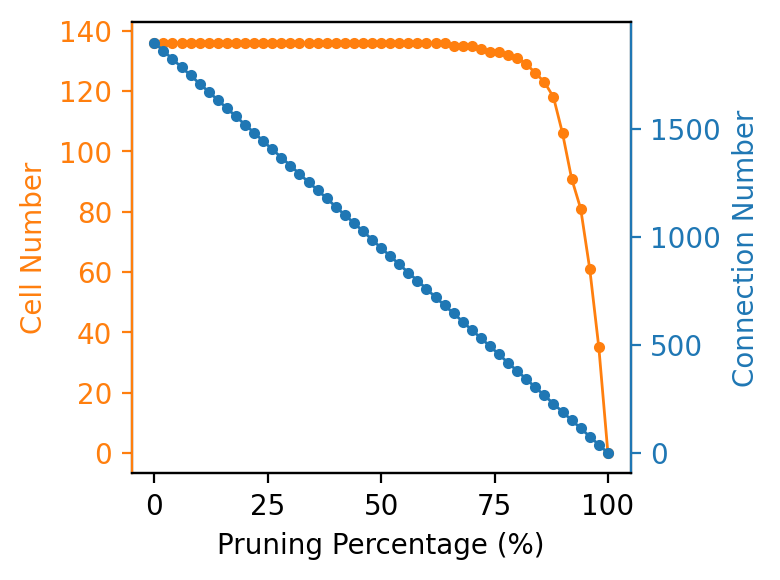

In [37]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.add_subplot(1,1,1)
h1 = ax.plot(percentage_list, cell_cnt_list,'.-', c='C1', label='#Cell', linewidth = 1)
ax.set_ylabel('Cell Number')
ax.set_xlabel('Pruning Percentage (%)')
ax2 = ax.twinx()
h2, = ax2.plot(percentage_list, conn_cnt_list, '.-', c='C0', label='#Connection', linewidth = 1)
ax2.set_ylabel('Connection Number')
ax2.spines['left'].set_color('C1')
ax2.spines['right'].set_color('C0')
ax.tick_params(axis='y', colors='C1')
ax2.tick_params(axis='y', colors='C0')
ax.yaxis.label.set_color('C1')
ax2.yaxis.label.set_color('C0')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, "prune_conn.png"))

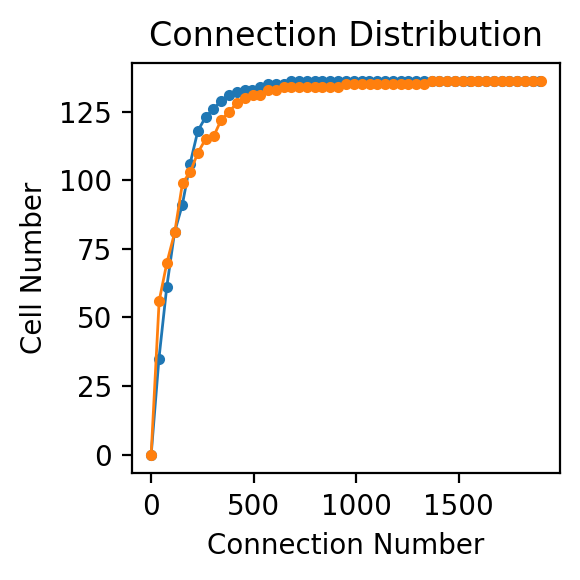

In [10]:
plt.figure(figsize=(3, 3), dpi=200)
plt.plot(conn_cnt_list, cell_cnt_list,'.-', c='C0', label='#Cell', linewidth = 1)
plt.plot(conn_cnt_list2, cell_cnt_list2,'.-', c='C1', label='#Cell', linewidth = 1)
plt.title("Connection Distribution")
plt.xlabel('Connection Number')
plt.ylabel('Cell Number')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, "connection_distribution.png"))